# DATA 558 - Homework 3
Will Wright

***
## Exercise 1

In this exercise, you will implement in **Python** a first version of _your own fast gradient algorithm_ to solve the $\ell_2^2$-regularized logistic regression problem.  
Recall from the lectures that the logistic regression problem writes as:  
$$\min_{\mathbf{\beta \in \mathbb{R}^d}} F(\beta):=\frac{1}{n}\sum_{i=1}^{n} log(1+exp(-y_ix_i^T\beta)) + \lambda\lVert\beta\rVert_2^2 \tag{1}$$


We use here the machine learning convention for the labels that is $y_i\in${−1, +1}.

### 1.1 Fast Gradient
The fast gradient algorithm is outlined in Algorithm 1. The algorithm requires a subroutine that computes the gradient for any $\beta$.  

Assume that $d=1$ and $n=1$. The sample is then of size 1 and boils down to just $(x, y)$. The function $F$ writes simply as:  

$F(\beta)=log(1+exp(-yx\beta))+\lambda\beta^2$  

**Question**  
Compute and write down the gradient $\nabla F$ of $F$.

**Solution**  
We can break up the sum $log(1+exp(-yx\beta))+\lambda\beta^2$ into two parts: (1) $log(1+exp(-yx\beta))$ and (2) $\lambda\beta^2$ and derive each separately.  

(1) $\frac{\partial}{\partial \beta}log(1+exp(-yx\beta))$  



Use the chain rule with the following functions and their derivatives:  
$(f\circ g \circ h) = log(g\circ h)$  
$(f\circ g \circ h)' = \frac{1}{g\circ h} \cdot (g \circ h)' $  
$(g\circ h) = 1+exp(-h)$  
$(g\circ h)' = -exp(-h)\cdot h'$  
$h = yx\beta$  
$h' = yx$  
  
Putting the chains together, we have:  
$(f\circ g \circ h)' = \frac{-yx\cdot exp(-yx\beta)}{1+exp(-yx\beta)}$
  

(2) $\frac{\partial}{\partial \beta}\lambda\beta^2 = 2\lambda \beta$  
  
Finally, we add (1) and (2) to get:  
$\nabla F = \frac{-yx\cdot exp(-yx\beta)}{1+exp(-yx\beta)} + 2\lambda \beta$  





**Question**  
Assume now that $d>1$ and $n>1$.  Using the previous result and the linearity of differentiation, compute and write down the gradient $\nabla F(\beta)$ of $F$.

**Solution**  
We can break up the sum $log(1+exp(-y_ix_i^T\beta))+\lambda\lVert \beta\rVert_2^2$ into two parts: (1) $log(1+exp(-y_ix_i^T\beta))$ and (2) $\lambda\lVert \beta\rVert_2^2$ and derive each separately.  

(1) $\frac{\partial}{\partial \beta}log(1+exp(-y_ix_i^T\beta))$  
  
Use the chain rule with the following functions and their derivatives:  
$(f\circ g \circ h) = log(g\circ h)$  
$(f\circ g \circ h)' = \frac{1}{(g\circ h)} \cdot (g \circ h)' $  
$(g\circ h) = 1+exp(-h)$  
$(g\circ h)' = -exp(-h)\cdot h'$  
$h = y_ix_i^T\beta$  
$h' = y_ix_i$  
  
Putting the chains together, we have:  
$(f\circ g \circ h)' = -y_ix_i \cdot \frac{-y_ix_iexp(-y_ix_i^T\beta)}{1+exp(-y_ix_i^T\beta)}$
  
(2) $\frac{\partial}{\partial \beta}\lambda\lVert \beta\rVert_2^2 = 2\lambda \beta $  
  
Next, we add (1) and (2) to get:  
$\nabla F = -y_ix_i\cdot \frac{exp(-y_ix_i^T\beta)}{1+exp(-y_ix_i^T\beta)} + 2\lambda \beta$
  
As as added simplification (to be used in the code below), we can substitude:  
$1-p_i = \frac{exp(-y_ix_i^T\beta)}{1+exp(-y_ix_i^T\beta)}$

...and arrive at:  
$\nabla F = -y_ix_i(1-p_i) + 2\lambda \beta$  

If P is an nxn matrix of 0s with diag(P) = $1-p_i$, then we can simply to the final form:  
$\nabla F = -\frac{1}{n}XYP + 2\lambda \beta$

Consider the Spam dataset from The Elements of Statistical Learning (You can get it here: https://web.stanford.edu/~hastie/ElemStatLearn/). Standardize the data (i.e., center the features and divide them by their standard deviation, and also change the output labels to +/- 1).

In [1]:
# Load Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import copy
from scipy.linalg import eigh as largest_eigh # for calculating the initial eta
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

spam = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data', 
                   delim_whitespace=True, header = None)

In [2]:
X = spam.iloc[:,0:57]
y = spam.iloc[:,-1]
y = y.replace(0,-1)

# Divide the data into training and test sets. By default, 25% goes into the test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Convert to array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Standardize data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Write a function _computegrad_ that computes and returns $\nabla F(\beta)$ for any $\beta$.

In [3]:
def computegrad(X, y, beta, lam = 0.05):
    'Output grad(F) given X, y, beta, and lambda'
    ## calc the nxn p-matrix
    # start with the diagonal of non-zeros
    n = X.shape[0]
    d = X.shape[1]
    P_diag = [0 for x in range(n)] # P is nxn
    for i in range(0,n):
        yXTbeta = y[i]*(X[i,:].T).dot(beta) # 1x1 * dx1 * 1xd = 1x1
        P_diag[i] = 1-(np.exp(yXTbeta))/(1+np.exp(yXTbeta)) 
    P = np.diagflat(P_diag) # nxn
    emp_risk = (-1/n)*(X.T.dot(P).dot(y)).reshape(d,1) # (dxn * nxn) = dxn; dxn * nx1 = dx1
    penalty = 2*lam*beta.reshape(d,1) # dx1
    grad_F = emp_risk + penalty #dx1 + dx1 = dx1
    return grad_F

In [4]:
def computeobj(X, y, beta, lam = 0.05):
    'Output F (objective is to minimize) for any given X, y, beta, lam'
    n = X.shape[0]
    sum_terms = [0 for i in range(n)] # initialize list
    for i in range(0, n):
        sum_terms[i] = np.log(1+np.exp(-y[i]*X[i,:].T.dot(beta)))
    avg_summation = sum(sum_terms)/n
    regularization = lam*np.sum(beta**2)
    F = avg_summation + regularization
    return F

Write a function _backtracking_ that implements the backtracking rule.

In [5]:
def backtracking(X, y, beta, eta, alpha = 0.5, gamma = 0.8):
    'Output new eta for a given X, y, beta, eta, alpha, and gamma'
    grad = computegrad(X,y,beta)
    complete = False
    while complete == False:
        if computeobj(X, y, beta - eta*grad) < computeobj(X, y, beta) - alpha*eta*np.linalg.norm(grad)**2:
            complete = True
        else:
            eta = eta * gamma
    return eta

Write a function _graddescent_ that implements the gradient descent algorithm with the backtracking rule to tune the step-size. The function _graddescent_ calls _computegrad_ and _backtracking_ as subroutines. The function takes as input the initial point, the initial step-size value, and the target accuracy $\epsilon$. The stopping criterion is $\lVert \nabla F \rVert \leq \epsilon$.

In [6]:
def compute_eta(X, lam = 0.05):
    'returns initial step-size based on equation provided in lecture notes'
    eigenValues, eigenVectors = np.linalg.eig((1/len(X)) * X.T.dot(X))
    L = max(eigenValues) + lam
    return 1/L

In [7]:
def graddescent(X, y, eta, target = 10e-4, lam = 0.05):
    # initialize lists of betas, Fs, and grad(F)s
    beta = np.zeros((X.shape[1],1))
    betas =[beta] #start with the first beta included
    Fs = [computeobj(X,y,beta,lam)] # start with the first F included
    grad = computegrad(X,y,beta,lam)
    t=0
    while (np.linalg.norm(grad)>target):
        eta = backtracking(X, y, beta, eta)
        beta = beta - eta*grad
        betas.append(beta) 
        F = computeobj(X, y, beta, lam)
        Fs.append(F) 
        grad = computegrad(X, y, beta, lam)
        t += 1
    return np.array(betas), np.array(Fs)
    

Write a function _fastgradalgo_ that implements the fast gradient algorithm described in Algorithm 1. The function _fastgradalgo_ calls _computegrad_ and _backtracking_ as subroutines. The function takes as input the initial step-size value for the backtracking rule and the target accuracy $\epsilon$. The stopping criterion is $\lVert \nabla F \rVert \leq \epsilon$.

In [8]:
def fastgradalgo(X, y, eta, target = 10e-4, lam = 0.05):
    # initialize lists of betas, Fs, and grad(F)s
    # identical to standard gradient descent except theta is added and used in the computegrad subroutine
    beta = np.zeros((X.shape[1],1))
    theta = np.zeros((X.shape[1],1))
    betas = [beta] #start with the first beta included
    Fs = [computeobj(X,y,beta,lam)] # start with the first F included
    grad = computegrad(X,y,theta,lam)
    t=0
    while (np.linalg.norm(grad) > target):
        eta = backtracking(X, y, beta, eta)
        beta_prior = copy.copy(beta)
        beta = theta - eta * computegrad(X, y, theta, lam)
        theta = beta + (t/(t+3))*(beta - beta_prior)
        betas.append(beta)
        F = computeobj(X, y, beta, lam)
        Fs.append(F) 
        grad = computegrad(X, y, theta, lam)
        t += 1
    return np.array(betas), np.array(Fs)

Use the estimate described in the course to initialize the step-size. Set the target accuracy to $\epsilon = 10^{−4}$. Run _graddescent_ and _fastgradalgo_ on the training set of the Spam dataset for $\lambda = 0.1$. Plot the curve of the objective values $F(\beta_t)$ for both algorithms versus the iteration counter $t$ (use different colors). What do you observe?

In [9]:
results_graddescent = graddescent(X_train, y_train, eta = compute_eta(X_train, lam = 0.1), target = 10e-4, lam = 0.1)
results_fastdescent = fastgradalgo(X_train, y_train, eta = compute_eta(X_train, lam = 0.1), target = 10e-4, lam = 0.1)

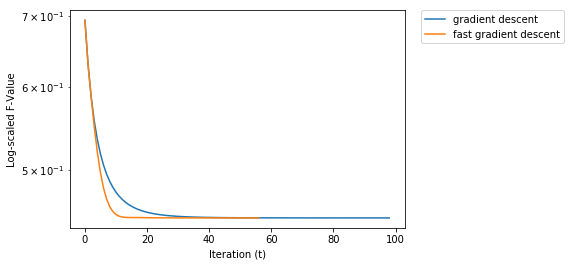

In [10]:
plt.plot(results_graddescent[1], label = "gradient descent")
plt.plot(results_fastdescent[1], label = "fast gradient descent")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Log-scaled F-Value')
plt.xlabel('Iteration (t)')
plt.yscale('log')
plt.show()

In [11]:
print("Gradient descent took",results_graddescent[0].shape[0],
      "iterations while fast gradient descent took only",results_fastdescent[0].shape[0])

Gradient descent took 99 iterations while fast gradient descent took only 57


Denote by $\beta_T$ the final iterate of your fast gradient algorithm. Compare $\beta_T$ to the $\beta^{*}$ found by scikit-learn. Compare the objective value for $\beta_T$ to the one for $\beta^{*}$. What do you observe?

In [12]:
beta_T = results_fastdescent[0][-1]

In [13]:
classifier = LogisticRegression(penalty='l2', dual=False, C=1/0.1, tol=10e-4, fit_intercept=False, solver='saga')
classifier.fit(X_train, y_train)

C:\Users\Will\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.001, verbose=0, warm_start=False)

In [14]:
beta_comparison = pd.DataFrame(np.concatenate((beta_T,classifier.coef_.T),axis=1), columns = ['fastgrad_betas','sklearn_betas'])
beta_comparison['beta_diff'] = beta_comparison['fastgrad_betas'] - beta_comparison['sklearn_betas']
beta_comparison

,fastgrad_betas,sklearn_betas,beta_diff
0,0.029713,-0.044628,0.074341
1,-0.022302,-0.113361,0.091058
2,0.086928,0.097073,-0.010146
3,0.058870,0.484505,-0.425635
4,0.175014,0.437646,-0.262631
5,0.120720,0.138895,-0.018175
6,0.295621,1.440964,-1.145342
7,0.131526,0.224513,-0.092986
8,0.121934,0.174459,-0.052525
9,0.050707,0.032233,0.018473


In [15]:
fastgrad_obj = results_fastdescent[1][-1]
fastgrad_obj

array([0.45068687])

In [16]:
sklearn_obj = computeobj(X_train, y_train, classifier.coef_.T)
sklearn_obj

array([0.97786854])

$\beta_T$ is smaller than $\beta_*$.  This could possibly be due to the type of solver being used or a different alpha/gamma.

Run cross-validation on the training set of the Spam dataset using _scikit-learn_ to find the optimal value of $\lambda$. Run _graddescent_ and _fastgradalgo_ to optimize the objective with that value of $\lambda$. Plot the curve of the objective values $F(\beta_t)$ for both algorithms versus the iteration counter $t$. Plot the misclassification error on the training set for both algorithms versus the iteration counter $t$. Plot the misclassification error on the test set for both algorithms versus the iteration counter $t$. What do you observe?

**[Come back to this]**

In [18]:
classifier.score(X_test, y_test)

0.8992180712423979

***
## Exercise 2

Suppose we estimate the regression coefficients in a logistic regression model by minimizing

$$F(\beta):=\frac{1}{n}\sum_{i=1}^{n} log(1+exp(-y_ix_i^T\beta)) + \lambda\lVert\beta\rVert_2^2$$

for a particular value of $\lambda$. For parts (a) through (b), indicate which of (i) through (v) is correct. Justify your answer.

&emsp;(a) As we increase $\lambda$ from 0, the misclassification error on the test set will:  
&emsp;&emsp;(i) Increase initially and then eventually start decreasing in an inverted U shape.  
&emsp;&emsp;(ii) Decrease initially and then eventually start increasing in a U shape.  
&emsp;&emsp;(iii) Steadily increase.  
&emsp;&emsp;(iv) Steadily decrease.  
&emsp;&emsp;(v) Remain constant.  

**Answer**: (ii) Decrease initially and then eventually start increasing in a U-shape.  This is because the misclassification error  is an additive function of bias and variance where bias increases in an S-shape with $\lambda$ and variance decreases in an S-shape with $\lambda$. Due to this bias-variance trade-off, the error forms a U-shape with a minimum point for the optimal $\lambda$.

&emsp;&emsp;(b) Repeat (a) for the misclassification error on the training set.

**[Come back to this]** I think this question is asking for a chart showing MSE, bias, and variance with $\lambda$ on the x-axis

***
## Exercise 3
In this exercise, you will use Amazon Web Services (AWS) to run a nearest neighbors algorithm on data from the Sloan Digital Sky Survey.  The goals of this exercise are:  
&emsp;1. To teach you how to use AWS's Elastic Compute Cloud (EC2) and Simple Storage Service (S3)  
&emsp;2. To show you that computing with GPUs can be much faster than computing with CPUs  
&emsp;3. To demonstrate a fast algorithm for computing nearest neighbors (from [1])  

**Background:** The Sloan Digital Sky Survey (SDSS) has gathered data on many objects in the sky. The data set you will use in this assignment consists of (1) a “training” set of pho- tometric data on known astronomical objects; and (2) a “test” set of additional photometric data on more objects. Astronomers often need to determine which objects in a new data set are worth further examination because their telescope time is very limited. By finding the nearest neighbors in the training set to each object in the test set, they can tell whether the object is interesting or not. For example, if an object in the test set is closest to sun-like stars, then they might find that one very boring and not follow up on it.  

**Instructions:** Following the AWS tutorial for help, do the following:  
&emsp;1. Create a p2.xlarge spot instance with the “Deep Learning AMI (Ubuntu) Version 22.0” AMI. If this instance type doesn’t work, try another one of the gpu instances. You need to use a GPU instance for this assignment.  

&emsp;2. Install Swig and bufferkdtree on your instance.  

&emsp;3. On your instance, run the astronomy example from here https://github.com/gieseke/bufferkdtree/tree/master/examples and save all of the output to the file “out- put.txt”. **Hint:** You will need to transfer both astronomy.py and generate.py on EC2. In addition, in the file astronomy.py you will need to change the line  
plat dev ids = {0:[0 ,1 ,2 ,3]} to  
plat dev ids = {0:[0]}  
The data will automatically download the first time you run it **after user input**. Therefore, do not try to save the output to a file via > the first time you run it or else it will hang indefinitely. Either use the tee command (https://en.wikipedia. org/wiki/Tee_(command)), run the script once before using > or copy and paste the output to a file. If you are still having issues with it hanging when saving directly to a file, check the output file. It’s possible that it finished writing out the output.  

&emsp;4. Transfer the file output.txt to an S3 bucket.  

&emsp;Go t the S3 interface https://console.aws.amazon.com/s3/home?region=us-east-1 and make that file public.  

&emsp;In your homework submission please include the following:  

&emsp;&emsp;(a) The fitting and testing times on both the CPU and GPU versions. You can find these in the output.  

&emsp;&emsp;(b) The url from the previous step (Check to make sure you successfully made it public!)  

&emsp;&emsp;(c) A statement of any problems you encountered during this exercise and how you overcame them (or if you didn’t).  

&emsp;&emsp;(d) How long it took you to complete this exercise (for our reference–we’re not grading you on how long it took).  

***
## Exercise 4
Read the announcement “Data Competition, Part 1” released on Canvas. We strongly recommend you perform this task on AWS. You will use your own $\ell_2^2$_-regularized logistic regression_ for this exercise. After completing this exercise, submit your predictions to the data competition Kaggle website.  

&emsp;Download the data for the Kaggle competition. Run the script extract features.py to extract features from the images. This script was written in Python 3 and depends on the library PyTorch.  

&emsp;Pick two classes of your choice from the dataset. Train an $\ell_2^2$_-regularized logistic regression_ classifier on the training set using your own fast gradient algorithm with $\lambda$ = 1. Be sure to use the features you generated above rather than the raw image features. Plot, with different colors, the _misclassification error_ on the training set and on the validation set vs iterations.  

&emsp;Find the value of the regularization parameter $\lambda$ using cross-validation; you may use scikit-learn’s built-in functions for this purpose. Train an $\ell_2^2$_-regularized logistic regression_ classifier on the training set using your own fast gradient algorithm with that value of $\lambda$ found by cross-validation. Plot, with different colors, the misclassification error on the training set and on the validation set vs iterations.  


***
## Exercise 5 (Optional)
It is well-known that ridge regression tends to give similar coefficient values to correlated variables, whereas the lasso may give quite different coefficient values to correlated variables. We will now explore this property in a very simple setting.  

Suppose that $n = 2, p = 2, x_11 = x_12, x_21 = x_22$. Furthermore, suppose that $y_1 + y_2 = 0$ and $x_11 + x_21 = 0$ and $x_12 + x_22 = 0$, so that the estimate for the intercept in a least squares, ridge regression, or lasso model is zero: $\hat{β}_0 = 0$.  

&emsp;(a) Write out the ridge regression optimization problem in this setting.  

&emsp;(b) Argue that in this setting, the ridge coefficient estimates satisfy $\beta_1 = \beta_2$.  